In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from PIL import Image

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers  import Input, Dense, Dropout, Flatten, Conv2D,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras import utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.python.keras.layers import concatenate
from tensorflow.python.keras.models import Model
#from tensorflow.python.layers.merge import concatenate

np.random.seed(42)

%matplotlib inline

In [8]:
# Directory paths
train_dir = "../input/chest_xray_3classes/chest_xray/train"
val_dir = "../input/chest_xray_3classes/chest_xray/val"
test_dir = "../input/chest_xray_3classes/chest_xray/test"

models = list()

In [9]:
# resnet50
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50

model_res = Sequential()

model_res.add(ResNet50(include_top = False,
                   weights = "imagenet",
                   input_shape=(150,150,3)))

# Dropout
model_res.add(Dropout(0.5))

# Pooling layer
model_res.add(GlobalAveragePooling2D())

# Dense layer
model_res.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model_res.add(BatchNormalization())

# Output layer
model_res.add(Dense(3,
                activation = "softmax"))

#Load weights 
model_res.load_weights("../output/3classes_resnet50_model.h5")

for layer in model_res.layers:
    # make not trainable
    layer.trainable = False

In [10]:
# InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

model_in = Sequential()

model_in.add(InceptionV3(include_top = False,
                      weights = 'imagenet',
                      input_shape=(150,150,3)))

# Dropout
model_in.add(Dropout(0.5))

# Pooling layer
model_in.add(GlobalAveragePooling2D())

# Dense layer
model_in.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model_in.add(BatchNormalization())

# Output layer
model_in.add(Dense(3,
                activation = "softmax"))

#Load weights 
model_in.load_weights("../output/3classes_inception_model.h5")

for layer in model_in.layers:
    # make not trainable
    layer.trainable = False

In [11]:
# a single input layer
inputs = Input(shape=(150,150,3))

# model 1
x1 = model_res(inputs)

# model 2 
x2 = model_in(inputs)

# merging models
x3 = concatenate([x1, x2])

# output layer
predictions = Dense(3, activation='softmax')(x3)

# generate a model from the layers above
model = Model(inputs=inputs, outputs=predictions)

#Load weights 
model.load_weights("../output/3classes_ensemble_step3.h5")

In [12]:
# check size
model.input, model.output

(<tf.Tensor 'input_3:0' shape=(None, 150, 150, 3) dtype=float32>,
 <tf.Tensor 'dense_4/Identity:0' shape=(None, 3) dtype=float32>)

In [13]:
# Early Stopping
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 10)
# Compile model
model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(lr = 0.0001),
              metrics = ["accuracy"])

In [14]:
# Input shape
model.input_shape[1:3]

(150, 150)

In [15]:
# Data Generator 

#Defining image augmentation
train_idg = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               rotation_range = 20,
                               horizontal_flip = True)

test_idg = ImageDataGenerator(rescale = 1./255)

#Creating data loaders
train_gen = train_idg.flow_from_directory(train_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, #8,16,32
                                    shuffle = True)

val_gen =  test_idg.flow_from_directory(val_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, 
                                    shuffle = True)

test_gen = test_idg.flow_from_directory(test_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 8,
                                    shuffle = False)

Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [16]:
# Fit model
hist = model.fit_generator(train_gen, 
                    validation_data = val_gen,
                    callbacks = [early_stop],
                    epochs = 30)

Epoch 1/30
326/326 [==============================] - 1843s 6s/step - loss: 0.3617 - accuracy: 0.8577 - val_loss: 0.8091 - val_accuracy: 0.5625
Epoch 2/30
326/326 [==============================] - 1733s 5s/step - loss: 0.3516 - accuracy: 0.8660 - val_loss: 0.8109 - val_accuracy: 0.5625
Epoch 3/30
326/326 [==============================] - 1649s 5s/step - loss: 0.3530 - accuracy: 0.8629 - val_loss: 0.8135 - val_accuracy: 0.5625
Epoch 4/30
326/326 [==============================] - 1669s 5s/step - loss: 0.3504 - accuracy: 0.8585 - val_loss: 0.8162 - val_accuracy: 0.5625
Epoch 5/30
326/326 [==============================] - 1631s 5s/step - loss: 0.3509 - accuracy: 0.8618 - val_loss: 0.8182 - val_accuracy: 0.5625
Epoch 6/30
326/326 [==============================] - 1558s 5s/step - loss: 0.3498 - accuracy: 0.8620 - val_loss: 0.8203 - val_accuracy: 0.5625
Epoch 7/30
326/326 [==============================] - 1473s 5s/step - loss: 0.3470 - accuracy: 0.8633 - val_loss: 0.8222 - val_accuracy:

In [17]:
# Evaluate model on test data.
scores = model.evaluate_generator(test_gen)
labels = model.metrics_names

# Show model performance
print(f'{labels[0]}: {scores[0]}')
print(f'{labels[1]}: {scores[1]* 100}%')

# Summary of the layers of the model
#model.summary()

loss: 0.4416709792537567
accuracy: 86.05769276618958%


In [18]:
# Predicted classes - Predicted Positives and Predicted Negatives 
predictions = model.predict(test_gen)
pred_0 = predictions[:,0]
pred_1 = predictions[:,1]
pred_2 = predictions[:,2]
predicted_classes = np.argmax(predictions,axis=1)

# True classes - True Positives and True Negatives 
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys()) 

In [19]:
# Create Report
report = metrics.classification_report(true_classes, 
                                       predicted_classes, 
                                       target_names = class_labels)
print(report)  

              precision    recall  f1-score   support

    BACTERIA       0.85      0.95      0.90       242
      NORMAL       0.97      0.81      0.88       234
       VIRUS       0.74      0.78      0.76       148

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.87      0.86      0.86       624



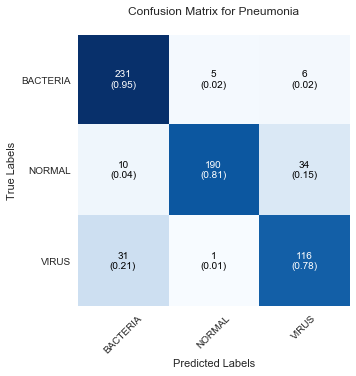

In [20]:
# Create Confusion Matrix
plt.style.use('seaborn')

cm = metrics.confusion_matrix(true_classes,predicted_classes)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5),
                                class_names = class_labels,
                                show_normed = True)
ax.set(title = "Confusion Matrix for Pneumonia",
       ylabel = "True Labels",
       xlabel = "Predicted Labels")
plt.show()

In [23]:
import copy

true_classes0 = copy.deepcopy(true_classes)
true_classes0[true_classes==0]=1
true_classes0[true_classes!=0]=0


true_classes1 = copy.deepcopy(true_classes)
true_classes1[true_classes==1]=1
true_classes1[true_classes!=1]=0


true_classes2 = copy.deepcopy(true_classes)
true_classes2[true_classes==2]=1
true_classes2[true_classes!=2]=0

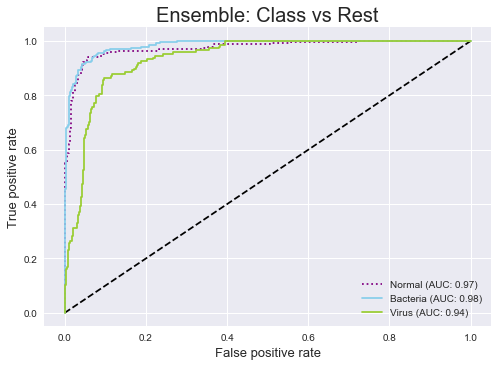

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr0, tpr0, _ = roc_curve(true_classes0, pred_0)
fpr1, tpr1, _ = roc_curve(true_classes1, pred_1)
fpr2, tpr2, _ = roc_curve(true_classes2, pred_2)


# ROC curve graph for all models

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr0, tpr0, label='Normal (AUC: %0.2f)'
             % auc(fpr0,tpr0), color= "purple",  linestyle=':')
plt.plot(fpr1, tpr1, label='Bacteria (AUC: %0.2f)'
             % auc(fpr1,tpr1), color = "skyblue")
plt.plot(fpr2, tpr2, label='Virus (AUC: %0.2f)'
             % auc(fpr2,tpr2), color = "yellowgreen")
plt.xlabel('False positive rate', fontsize = 13)
plt.ylabel('True positive rate', fontsize = 13)
plt.title('Ensemble: Class vs Rest', fontsize = 20)
plt.legend(loc='best')
plt.show()

source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [25]:
# save weights from this model model
model.save_weights("../output/3classes_ensemble_step4.h5")

### Three Class Classifcation Results
|             	| Accuracy 	| AUROC                        	| Recall                       	| Precision                     	|
|:-----------:	|----------	|------------------------------	|------------------------------	|-------------------------------	|
| InceptionV3 	| 85.7%    	| 0.98 (B)  0.97 (N)  0.94 (V) 	| 0.95 (B)  0.82 (N)  0. 77(V) 	| 0.85 (B)   0.95 (N)  0.75 (V) 	|
| Resnet50    	| 81.7%    	| 0.97 (B)  0.96 (N)  0.91 (V) 	| 0.90 (B)  0.75 (N)  0.78 (V) 	| 0.82 (B)  0.97 (N)  0.65 (V)  	|
| Ensemble    	| 86.1%    	| 0.98 (B)  0.97(N)  0.94 (V)  	| 0.95 (B)  0.81 (N)  0.78 (V) 	| 0.85 (B)  0.97 (N)  0.75 (V)  	|